# Police Dispatch Optimization using Machine Learning

##### Avner Khan, Kiran Raja, Abhishek Khare, Joshua Deng

## Imports and Connecting to Darwin

In the below cells, we define all of the our imports that we utilize in our project and login to darwin.

In [1]:

import matplotlib.pyplot as plt
from amb_sdk.sdk import DarwinSdk
from time import sleep
import pandas as pd
import numpy as np
import sklearn.model_selection as ms
from sklearn.metrics import classification_report
import datetime

ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())


In [2]:
#Create a new user
status, msg = ds.auth_login_user('KIRAN.RAJA22@GMAIL.COM', 'EgN5NagB3D')
if not status:
    print(msg)
print(status)

True


## Feature Engineering

In the below cells, we feature engineer by turning features "Occured Date", "Occured Time", "Report Date", and "Report Time" into a single feature "Elapsed Time". We also drop features such as "Location", "Category Description", "UCR Category", "PRA", "APD District". Lastly, we use list-wise deletion to clear any NaN entries.

In [3]:
def elapsed_time(oc_date, oc_time, rep_date, rep_time):
    oc_date_split_arr = oc_date.split("/")
    oc_date_month = oc_date_split_arr[0]
    oc_date_day = oc_date_split_arr[1]
    oc_date_year = oc_date_split_arr[2]
    oc_hr = int(oc_time // 100)
    if (oc_hr > 23):
        oc_hr = 23
    elif (oc_hr < 0):
        oc_hr = 0
    oc_min = int(oc_time % 100)
    if (oc_min > 59):
        oc_min = 59
    elif (oc_min < 0):
        oc_min = 0
    oc_datetime = datetime.datetime(int(oc_date_year), int(oc_date_month), int(oc_date_day), oc_hr, oc_min)
    rep_date_split_arr = rep_date.split("/")
    rep_date_month = rep_date_split_arr[0]
    rep_date_day = rep_date_split_arr[1]
    rep_date_year = rep_date_split_arr[2]
    rep_hr = int(rep_time // 100)
    if (rep_hr > 23):
        rep_hr = 23
    elif (rep_hr < 0):
        rep_hr = 0
    rep_min = int(rep_time % 100)
    if (rep_min > 59):
        rep_min = 59
    elif (rep_min < 0):
        rep_min = 0
    rep_datetime = datetime.datetime(int(rep_date_year), int(rep_date_month), int(rep_date_day), rep_hr, rep_min)
    elapsed = rep_datetime - oc_datetime
    return (elapsed.total_seconds() / 3600), oc_datetime.weekday()

#Load data
dataset = pd.read_csv("Crime_Reports_Fixed_Labels.csv")
print('Original Length:', len(dataset))
print('Original Features:', list(dataset))
#Drop Unused Columns
dataset = dataset.drop(columns=['Location', 'Category Description', 'UCR Category', 'PRA', 'APD Sector', 'APD District', 'Council District', 'Zip Code', 'Address', 'Incident Number', 'Highest Offense Description', 'Occurred Date Time', 'Report Date Time', 'Clearance Date', 'X-coordinate', 'Y-coordinate', 'Latitude', 'Longitude', 'Single Member Council Districts', 'BOUNDARIES_single_member_districts', 'Zoning Review Cases_data'])
#Drop rows with missing data
dataset = dataset.dropna()
#Create Elapsed Time Field and add it to our data
elapsed = []
dow = []
for index, row in dataset.iterrows():
    el_time, day = elapsed_time(row['Occurred Date'], row['Occurred Time'], row['Report Date'], row['Report Time'])
    elapsed.append(el_time)
    dow.append(day)
elapsed_df = pd.DataFrame(data=elapsed)
dow_df = pd.DataFrame(data=dow)
dataset['Elapsed Time'] = elapsed_df
dataset['DOW'] = dow_df
dataset = dataset.drop(columns=['Occurred Date', 'Occurred Time', 'Report Date', 'Report Time'])
#Drop rows with missing data
dataset = dataset.dropna()
#Print Cleaned Data and save it as csv
print()
print('Cleaned Length:', len(dataset))
print('Remaining Features:', list(dataset))
print(dataset.head())
dataset.to_csv("Crime_Reports_Clean.csv", index=False)

C:\Users\kiran\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Original Length: 2124418
Original Features: ['Incident Number', 'Highest Offense Description', 'Highest Offense Code', 'Family Violence', 'Occurred Date Time', 'Occurred Date', 'Occurred Time', 'Report Date Time', 'Report Date', 'Report Time', 'Location Type', 'Address', 'Zip Code', 'Council District', 'APD Sector', 'APD District', 'PRA', 'Census Tract', 'Clearance Status', 'Clearance Date', 'UCR Category', 'Category Description', 'X-coordinate', 'Y-coordinate', 'Latitude', 'Longitude', 'Location', 'Zip Codes', 'Single Member Council Districts', 'BOUNDARIES_single_member_districts', 'Zoning Review Cases_data']

Cleaned Length: 1208611
Remaining Features: ['Highest Offense Code', 'Family Violence', 'Location Type', 'Census Tract', 'Clearance Status', 'Zip Codes', 'Elapsed Time', 'DOW']
    Highest Offense Code Family Violence                 Location Type  \
2                   2716               N                   RESTAURANTS   
3                   2716               N   DEPARTMENT / 

## Train/Test Splitting

In the code block below, we split our data into a training set and test set, with 80 percent being allocated to training and 20 percent being allocated to testing. We also export these into seperate CSVs for Darwin later on.

In [4]:
#Split and Save Train and Test Data
dataset = pd.read_csv("Crime_Reports_Clean.csv")
dataset = dataset.sample(frac=1)
train_data = dataset.iloc[:int(len(dataset)*.8)]
test_data = dataset.iloc[int(len(dataset)*.8):]
print('Train Data:', len(train_data))
print(train_data.head())
print()
print('Test Data:', len(test_data))
print(test_data.head())
train_data.to_csv("Crime_Reports_Train.csv", index=False)
test_data.to_csv("Crime_Reports_Test.csv", index=False)

Train Data: 966888
        Highest Offense Code Family Violence                 Location Type  \
477158                  2010               N         PARKING LOTS / GARAGE   
575285                  3200               N  STREETS / HWY / ROAD / ALLEY   
908532                   900               N              BAR / NIGHT CLUB   
912709                  3299               N  STREETS / HWY / ROAD / ALLEY   
911911                   604               N         PARKING LOTS / GARAGE   

        Census Tract Clearance Status  Zip Codes  Elapsed Time  DOW  
477158         18.39                N     3642.0      2.066667  3.0  
575285         17.54                N     3647.0      1.633333  4.0  
908532         23.10                N     3257.0      0.966667  4.0  
912709         11.00                C     2856.0      0.000000  4.0  
911911          3.07                N     2865.0      0.000000  6.0  

Test Data: 241723
         Highest Offense Code Family Violence  \
596864                  

## Upload Training Data 

Before we upload our data to Darwin, we delete the dataset to make sure there isn't a duplicate already running. After this, we upload and clean the training data with Darwin.

In [5]:
#Upload Train Data
status, message = ds.delete_dataset("Crime_Reports_Train.csv")
print(status, message)
status, uploaded_dataset = ds.upload_dataset("Crime_Reports_Train.csv")
if not status:
    print(uploaded_dataset)

#Clean Train Data
target = "Clearance Status"
status, job_id = ds.clean_data("Crime_Reports_Train.csv", target = target)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

True None
{'status': 'Requested', 'starttime': '2019-04-22T15:09:10.266842', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': ['9a3f69cf0db0496db3286e7fa1b08b6d'], 'model_name': None, 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-22T15:09:10.266842', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': ['9a3f69cf0db0496db3286e7fa1b08b6d'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T15:09:10.266842', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': ['9a3f69cf0db0496db3286e7fa1b08b6d'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T15:09:10.266842

## Model Creation

We create a unique identifier for our model using a timestamp, and then create a model based on the dataset we uploaded earlier. We trained this model from anywhere from 10 minutes to 1 hour.

In [6]:
#Creating Model
model = target + "_model" + ts
status, message = ds.delete_model(model)
print(status, message)
status, job_id = ds.create_model(dataset_names = "Crime_Reports_Train.csv", \
                                 model_name =  model, \
                                 max_train_time = '01:00')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)
    

False 400: BAD REQUEST - {"message": "Model does not exist"}

{'status': 'Requested', 'starttime': '2019-04-22T15:12:48.293183', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190422150542', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-22T15:12:48.293183', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190422150542', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T15:12:48.293183', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190422150542', 'job_error': ''}
{'status': 'Running', 

{'status': 'Running', 'starttime': '2019-04-22T15:12:48.293183', 'endtime': None, 'percent_complete': 3, 'job_type': 'TrainModel', 'loss': 0.4467881917953491, 'generations': 0, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190422150542', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T15:12:48.293183', 'endtime': None, 'percent_complete': 10, 'job_type': 'TrainModel', 'loss': 0.42655763030052185, 'generations': 1, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190422150542', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T15:12:48.293183', 'endtime': None, 'percent_complete': 10, 'job_type': 'TrainModel', 'loss': 0.42655763030052185, 'generations': 1, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190422150542', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-0

## Feature lmportance

Once we create our model, we get our feature importance which we can use to further analyze our model.

In [8]:
#Analyzing Models
# model = 'Clearance Status_model20190422150542'
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Requested', 'starttime': '2019-04-22T16:27:17.047551', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.41930097341537476, 'generations': 8, 'dataset_names': None, 'artifact_names': ['0618f9b8c6644901a6d34bd0133251df'], 'model_name': 'Clearance Status_model20190422150542', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T16:27:17.047551', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.41930097341537476, 'generations': 8, 'dataset_names': None, 'artifact_names': ['0618f9b8c6644901a6d34bd0133251df'], 'model_name': 'Clearance Status_model20190422150542', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T16:27:17.047551', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.41930097341537476, 'generations': 8, 'dataset_names': None, 'artifact_names': ['0618f9b8c6644901a6d34bd0133251df'], 'model_name': 'Clearance Status_model20190422150542', 'job_error': None

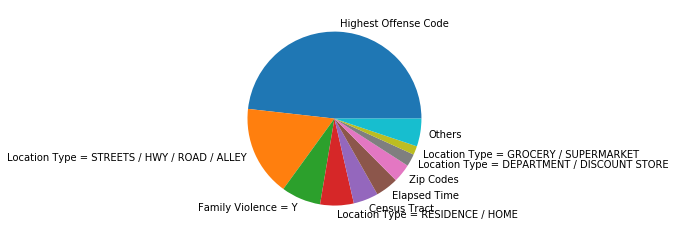

In [62]:
x=feature_importance[:9].append(pd.Series(sum(feature_importance[9:])))
labels=feature_importance.index[:9].append(pd.Index(["Others"]))
plt.pie(x, labels=labels, rotatelabels=False)
plt.show()

## Upload Test Data

We follow the same process that we used for uploading our training data, but instead, we are uploading the dataset that Darwin will use to test our data.

In [12]:
#Upload Test Data
status, message = ds.delete_dataset("Crime_Reports_Test.csv")
print(status, message)
status, dataset = ds.upload_dataset("Crime_Reports_Test.csv")
if not status:
    print(dataset)
    
#Clean Test Data
status, job_id = ds.clean_data("Crime_Reports_Test.csv", target = target, model_name = model)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

True None
{'status': 'Requested', 'starttime': '2019-04-22T17:11:56.839285', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['71b3c2f2cc3a4863bd35ce72b15681ee'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:11:56.839285', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['71b3c2f2cc3a4863bd35ce72b15681ee'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:11:56.839285', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['71b3c2f2cc3a4863bd35ce72b15681ee'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:11:56

{'status': 'Requested', 'starttime': '2019-04-22T17:11:56.839285', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['71b3c2f2cc3a4863bd35ce72b15681ee'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:11:56.839285', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['71b3c2f2cc3a4863bd35ce72b15681ee'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:11:56.839285', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['71b3c2f2cc3a4863bd35ce72b15681ee'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:11:56.839285', 

## Run Model and Results

We run our model on our test data, and receive our results. Our results include precision, recall, and f1-score. We also check out which model Darwin decided 

{'status': 'Requested', 'starttime': '2019-04-22T17:37:46.219795', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.41930097341537476, 'generations': 8, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['af1109bbe68a47e4a52dedd9ec9c9a0b'], 'model_name': 'Clearance Status_model20190422150542', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:37:46.219795', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.41930097341537476, 'generations': 8, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['af1109bbe68a47e4a52dedd9ec9c9a0b'], 'model_name': 'Clearance Status_model20190422150542', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:37:46.219795', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.41930097341537476, 'generations': 8, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['af1109bbe68a47e4a52dedd9ec9c9a0b'], 'model_name': 'Cl

{'status': 'Requested', 'starttime': '2019-04-22T17:37:46.219795', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.41930097341537476, 'generations': 8, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['af1109bbe68a47e4a52dedd9ec9c9a0b'], 'model_name': 'Clearance Status_model20190422150542', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:37:46.219795', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.41930097341537476, 'generations': 8, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['af1109bbe68a47e4a52dedd9ec9c9a0b'], 'model_name': 'Clearance Status_model20190422150542', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T17:37:46.219795', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.41930097341537476, 'generations': 8, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['af1109bbe68a47e4a52dedd9ec9c9a0b'], 'model_name': 'Cl

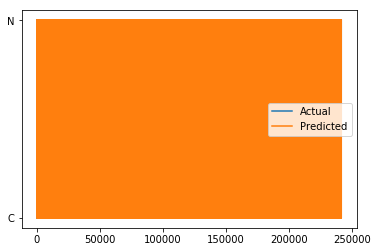

In [14]:
#Run Model on Test Data
status, artifact = ds.run_model("Crime_Reports_Test.csv", model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
df = pd.read_csv("Crime_Reports_Test.csv")
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(df[target], prediction[target]))

In [15]:
status, model_type = ds.lookup_model_name(model)
print(model_type['description']['best_genome'])

{'type': 'XGBClassifier', 'parameters': {'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.4929151042161634, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 13, 'n_estimators': 350, 'n_jobs': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.9147648101716959}}
